We started our journey by analysing our dataset ODIR-2019 
- https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k/data
- https://odir2019.grand-challenge.org/dataset/

From the dataset kaggle page:

> Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, 
> color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

> This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions. Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

> Normal (N),
> Diabetes (D),
> Glaucoma (G),
> Cataract (C),
> Age related Macular Degeneration (A),
> Hypertension (H),
> Pathological Myopia (M),
> Other diseases/abnormalities (O)

Also from the ODIR-2019 grand challenge website:

> The 5,000 patients in this challenge are divided into training, off-site testing and on-site testing subsets. Almost 4,000 cases are used in training stage while  others are for testing stages (off-site and on-site). Table 2 shows the distribution of case number with respect to eight labels in different stages. **Note: one patient may contains one or multiple labels.**

We supect that we have multi-label classification dataset, let's check whether this is multi-class or multi-label

References:
- https://pmc.ncbi.nlm.nih.gov/articles/PMC9230753/ Multi-Label Fundus Image Classification Using Attention Mechanisms and Feature Fusion  Zhenwei Li 1,*, Mengying Xu 1, Xiaoli Yang 1, Yanqi Han 1
- https://www.kaggle.com/datasets/efiyearcan/odir-5k-preprocessed-with-clahe
- https://www.kaggle.com/code/ahmetselukkren/preprocessing-with-clahe
- https://www.kaggle.com/code/umangtri/fundus-project-experiments
- https://www.kaggle.com/datasets/rohitrawat25/combined-fundus-images

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

data_set_path = 'ODIR-2019/dataset/full_df.csv'
data_set_img_path = 'ODIR-2019/dataset/preprocessed_images/'

let's define a function to display our image for visual inspection

In [3]:
import math
import os
import cv2
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10, w=512, h=512):
    plt.suptitle(title, fontsize=20)
    img_count = len(image_filenames)
    row_count = math.ceil(img_count / col_count)
    col_min = min(col_count,img_count)*5
    plt.figure(figsize=(15, 15))
    for i in range(1, img_count+1):
        plt.subplot(5, col_count, i)
        image_path=os.path.join(data_set_img_path, image_filenames[i-1])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (w, h))
        img = img / 255.
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_filenames[i-1].split('/')[-1]}")
        plt.axis(False);

Let us explore the dataset csv or index file to understand our data

In [4]:
df = pd.read_csv(data_set_path)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Let's convert label to python array

We need to simplify this table given there is information for both left and right eyes for the same patient ID in the same row.
Let's explore by viewing patient ID 0

In [6]:
df[df.ID==0]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg


The 2 rows for patient with ID 0 shows how the column relate to the each eye image. We should use filename as unique ID for each fundus file image, labels indicate whether patient has eye problem like cataract or normal. Let's check what are possible values for labels column.

In [7]:
df.labels.value_counts()

labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64

From label value, we realize that each fundus image only have 1 specific label. Hence, this is still a multi-class classification problem which make our problem simpler as we just need to assign 1 label to each image.

Let's simplify our data and remove factor like Age and Gender from our data.

In [21]:
from ast import literal_eval
df2= df[['filename', 'labels', 'ID', 'Left-Diagnostic Keywords','Right-Diagnostic Keywords']].copy()
df2['labels'] = df2['labels'].apply(literal_eval)
df2['labels'] = df2['labels'].apply(lambda x: x[0])
df2.rename(columns={'labels':'label'}, inplace=True)
map_label = {
    'N': 'Normal',
    'D': 'Diabetes',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'Ageing',
    'H': 'Hypertension',
    'M': 'Myopia',
    'O': 'Other diseases'
}
df2['class'] = df2['label'].map(map_label)
df2['lr'] = df2['filename'].apply(lambda f: f.split('_')[-1].split('.')[0])
df2['keywords']=np.where(df2['lr']=='right', df2['Right-Diagnostic Keywords'],df2['Left-Diagnostic Keywords'])
df2['keywords']=df2['keywords'].str.replace(',',' ')
df2['keywords']=df2['keywords'].str.replace('，',' ')
df2.head()

,filename,label,ID,Left-Diagnostic Keywords,Right-Diagnostic Keywords,class,lr,keywords
0,0_right.jpg,N,0,cataract,normal fundus,Normal,right,normal fundus
1,1_right.jpg,N,1,normal fundus,normal fundus,Normal,right,normal fundus
2,2_right.jpg,D,2,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,Diabetes,right,moderate non proliferative retinopathy
3,4_right.jpg,D,4,macular epiretinal membrane,mild nonproliferative retinopathy,Diabetes,right,mild nonproliferative retinopathy
4,5_right.jpg,D,5,moderate non proliferative retinopathy,moderate non proliferative retinopathy,Diabetes,right,moderate non proliferative retinopathy


Let's check for duplicate data also

In [22]:
num_duplicates = df.duplicated().sum()
print("exact duplicates : ", num_duplicates)
num_duplicates = df.duplicated(["filename"]).sum()
print("same filename duplicates : ",num_duplicates)


exact duplicates :  0
same filename duplicates :  0


we are aware of 2 possible noises "lens dust" and "optic disk photographically invisible" which may lead to wrong analysis
- lens dust : could be dust in camera or eyes
- optic disk photographically invisible : poor image where optic disc cannot be identified indicating low quality image
Let's check our data

In [10]:
print("optic disk photographically invisible:")
print("\t-current", len(df2[df2['keywords']=='optic disk photographically invisible']))
print("\t-left", len(df2[df2['Left-Diagnostic Keywords']=='optic disk photographically invisible']))
print("\t-right", len(df2[df2['Right-Diagnostic Keywords']=='optic disk photographically invisible']))
print("lens dust:")
print("\t-current", len(df2[df2['keywords'].str.contains("lens dust")]))
print("\t-right", len(df2[df2['Right-Diagnostic Keywords'].str.contains("lens dust")]))
print("\t-left", len(df2[df2['Left-Diagnostic Keywords'].str.contains("lens dust")]))


optic disk photographically invisible:
	-current 0
	-left 3
	-right 1
lens dust:
	-current 109
	-right 131
	-left 158


It seemed the "optic disk photographically invisible" images has already been excluded from our dataset
while "lens dust" still have 109 images.

Nevertheless let us double check "optic disk photographically invisible" by checking filename with left or right diagnostic keywords

In [23]:
df2[(df2['Left-Diagnostic Keywords']=='optic disk photographically invisible')| 
    (df2['Right-Diagnostic Keywords']=='optic disk photographically invisible')].head()

,filename,label,ID,Left-Diagnostic Keywords,Right-Diagnostic Keywords,class,lr,keywords
429,494_right.jpg,D,494,optic disk photographically invisible,moderate non proliferative retinopathy,Diabetes,right,moderate non proliferative retinopathy
1022,1254_right.jpg,G,1254,optic disk photographically invisible,glaucoma,Glaucoma,right,glaucoma
1072,1319_right.jpg,G,1319,optic disk photographically invisible,glaucoma,Glaucoma,right,glaucoma
4281,1369_left.jpg,G,1369,glaucoma,optic disk photographically invisible,Glaucoma,left,glaucoma


It seemed the images no longer contains "optic disk photographically invisible" 

If the "optic disk photographically invisible"  in Left-Diagnostic Keywords, the image filename is "right" image.

If the "optic disk photographically invisible"  in Right-Diagnostic Keywords, the image filename is "left" image.

Let us display the "lens dust" for inspection and then remove them

In [24]:
images_with_lens_dust = df2['keywords'].str.contains("lens dust")
images_with_lens_dust = df2[images_with_lens_dust]
images_with_lens_dust.head()

,filename,label,ID,Left-Diagnostic Keywords,Right-Diagnostic Keywords,class,lr,keywords
156,184_right.jpg,O,184,normal fundus，lens dust,epiretinal membrane over the macula，moderate n...,Other diseases,right,epiretinal membrane over the macula moderate n...
171,201_right.jpg,O,201,lens dust，moderate non proliferative retinopathy,macular epiretinal membrane，lens dust,Other diseases,right,macular epiretinal membrane lens dust
189,222_right.jpg,O,222,lens dust，normal fundus,vitreous degeneration，lens dust,Other diseases,right,vitreous degeneration lens dust
199,232_right.jpg,O,232,normal fundus，lens dust,epiretinal membrane，lens dust,Other diseases,right,epiretinal membrane lens dust
215,251_right.jpg,O,251,moderate non proliferative retinopathy,macular epiretinal membrane，lens dust，moderate...,Other diseases,right,macular epiretinal membrane lens dust moderate...


<Figure size 640x480 with 0 Axes>

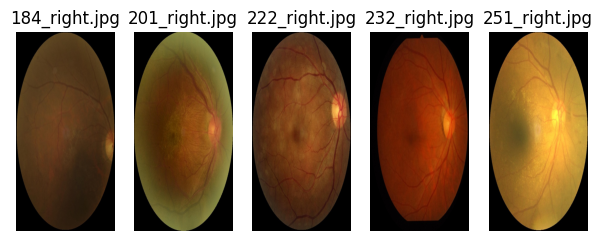

In [46]:
display_images(images_with_lens_dust["filename"].head(5).to_list())

In [26]:
condition_to_keep=~df2['keywords'].str.contains("lens dust")
df2 = df2[condition_to_keep]
print("contains lens dust ", len(df2[df2['keywords'].str.contains("lens dust")]))

contains lens dust  0


lets remove columns that we do not need anymore

In [27]:
df2=df2.drop(columns=['lr','Left-Diagnostic Keywords','Right-Diagnostic Keywords'])
df2.head()

,filename,label,ID,class,keywords
0,0_right.jpg,N,0,Normal,normal fundus
1,1_right.jpg,N,1,Normal,normal fundus
2,2_right.jpg,D,2,Diabetes,moderate non proliferative retinopathy
3,4_right.jpg,D,4,Diabetes,mild nonproliferative retinopathy
4,5_right.jpg,D,5,Diabetes,moderate non proliferative retinopathy


Some images may have been processed and differ greatly from pre-processed images. 
Ref : https://github.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/blob/2636f77ebb9aab42cc95f45ab680bbbbe5fcc715/list_discarded_images.md?plain=1#L180

From https://odir2019.grand-challenge.org/Download/ special explanation
>      The background of the following images is quite different from the rest ones. They are fundus images uploaded from the hospital. 
>	   We are sure that these images are preprocessed. You can decide by yourself whether or not to train these images in the model. 
>	   These images include
>		2174_right.jpg
>		2175_left.jpg
>		2176_left.jpg
>		2177_left.jpg
>		2177_right.jpg
>		2178_right.jpg
>		2179_left.jpg
>		2179_right.jpg
>		2180_left.jpg
>		2180_right.jpg
>		2181_left.jpg
>		2181_right.jpg
>		2182_left.jpg
>		2182_right.jpg
>		2957_left.jpg
>		2957_right.jpg
Let's display them 

<Figure size 640x480 with 0 Axes>

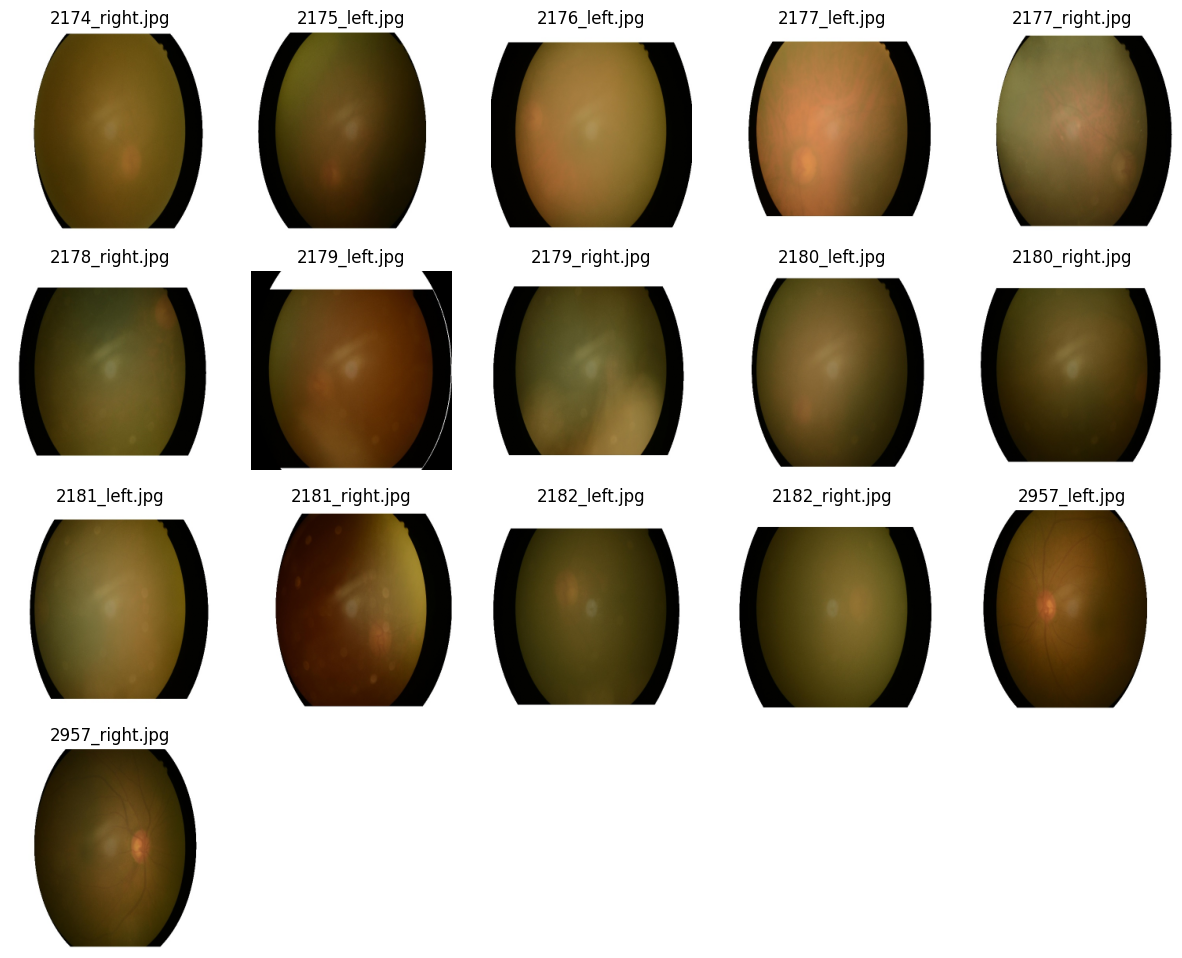

In [28]:
blacklist = ['2174_right.jpg', '2175_left.jpg', '2176_left.jpg', '2177_left.jpg', '2177_right.jpg',
                     '2178_right.jpg', '2179_left.jpg', '2179_right.jpg', '2180_left.jpg', '2180_right.jpg',
                     '2181_left.jpg', '2181_right.jpg', '2182_left.jpg', '2182_right.jpg', '2957_left.jpg',
                     '2957_right.jpg']
display_images(blacklist,title="blacklist", col_count=5, w=256,h=256)

<Figure size 640x480 with 0 Axes>

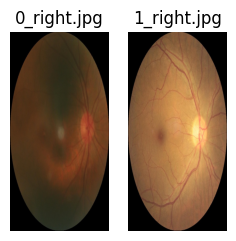

In [29]:
normal = ['0_right.jpg', '1_right.jpg']
display_images(normal,title="normal")


The images in blacklist are quite different, with white border and clipped eye. Hence, let us remove them.

In [30]:
print("before ",df2['filename'].isin(blacklist).sum())
condition_to_keep=~df2['filename'].isin(blacklist)
df2 = df2[condition_to_keep]
print("after" ,df2['filename'].isin(blacklist).sum())

before  15
after 0


Let us also check image sizes

In [31]:
def get_image_dimensions(image_path):
    """
    Gets the width and height of an image without loading the full raster data.

    Args:
        image_path (str): The path to the image file.

    Returns:
        tuple: A tuple containing (width, height) in pixels.
    """
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except IOError:
        print(f"Cannot open image file: {image_path}")
        return None, None
    
for index, row in df2.iterrows():
    image_path = data_set_img_path + row['filename']
    width, height = get_image_dimensions(image_path)
    index = hash(index)
    df2.at[index, 'width'] = width
    df2.at[index, 'height'] = height
    df2.at[index, 'wxh']  = f"{width}x{height}"

df2.head()

,filename,label,ID,class,keywords,width,height,wxh
0,0_right.jpg,N,0,Normal,normal fundus,512.0,512.0,512x512
1,1_right.jpg,N,1,Normal,normal fundus,512.0,512.0,512x512
2,2_right.jpg,D,2,Diabetes,moderate non proliferative retinopathy,512.0,512.0,512x512
3,4_right.jpg,D,4,Diabetes,mild nonproliferative retinopathy,512.0,512.0,512x512
4,5_right.jpg,D,5,Diabetes,moderate non proliferative retinopathy,512.0,512.0,512x512


In [32]:
df2.wxh.value_counts()

wxh
512x512    6268
Name: count, dtype: int64

Given all images have the same size, we can remove size columns

In [33]:
df2=df2.drop(columns=['wxh','width','height'])

Let's check our distribution to see whether we have imbalance dataset

[np.int64(2816), np.int64(3452)]


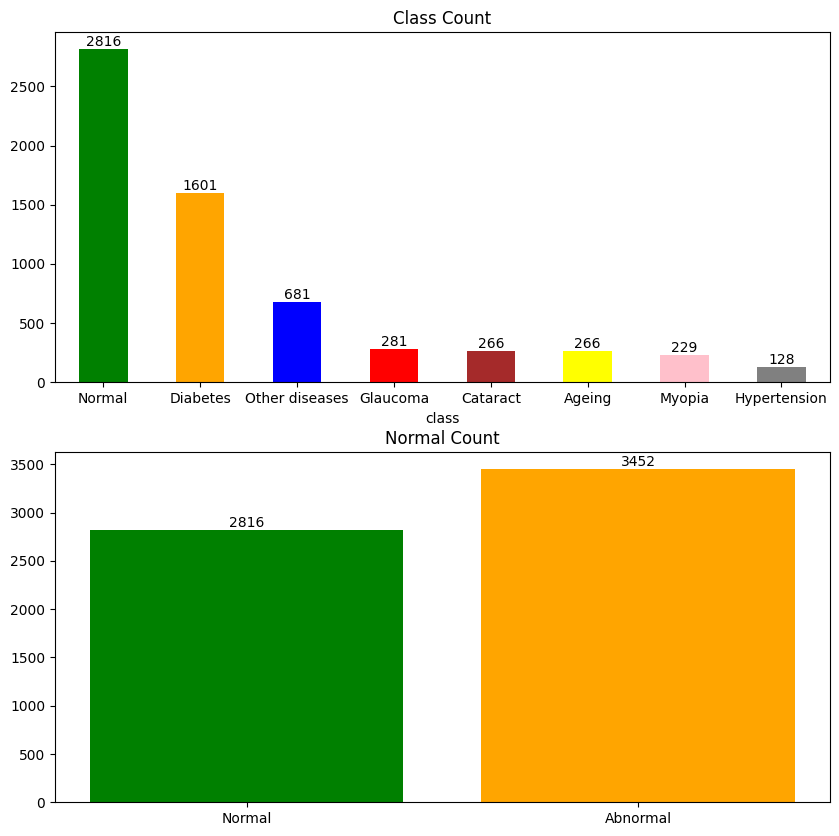

In [34]:
counts=df2['class'].value_counts()
normal_count=(df2['class']=='Normal').sum()
abnormal_count=(df2['class']!='Normal').sum()
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
counts.plot.bar(color=['green','orange','blue','red','brown','yellow','pink','gray'])
plt.title("Class Count")
plt.xticks(rotation=0) # Keeps x-axis labels horizontal
# Optional: Add value labels on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.subplot(2,1,2)
values=[normal_count, abnormal_count]
print(values)
plt.bar(['Normal','Abnormal'],values, color=['green', 'orange'])
plt.title("Normal Count")
plt.xticks(rotation=0) # Keeps x-axis labels horizontal
# Optional: Add value labels on top of the bars
for index, value in enumerate(values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

We do have an imbalanced dataset which we need to address for multi class classification

However, for binary classification, our data is reasonably balanced.

For now, let's split our data into training and test first

In [39]:
from sklearn.model_selection import train_test_split
y=df2['label']
X=df2.loc[:, df2.columns != 'label']
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25, random_state=42, shuffle=True, stratify=y)
print(f'Original DataFrame shape: {df2.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print("Train Data Set Output")
print(y_train.value_counts(normalize=True))
print("Test Data Set Output")
print(y_test.value_counts(normalize=True))

Original DataFrame shape: (6268, 5)
X_train shape: (4701, 4)
X_test shape: (1567, 4)
y_train shape: (4701,)
y_test shape: (1567,)
Train Data Set Output
label
N    0.449266
D    0.255478
O    0.108700
G    0.044884
A    0.042331
C    0.042331
M    0.036588
H    0.020421
Name: proportion, dtype: float64
Test Data Set Output
label
N    0.449266
D    0.255265
O    0.108488
G    0.044671
C    0.042757
A    0.042757
M    0.036375
H    0.020421
Name: proportion, dtype: float64


In [40]:
print("Train Data Set Output")
print(y_train.value_counts(normalize=False))

Train Data Set Output
label
N    2112
D    1201
O     511
G     211
A     199
C     199
M     172
H      96
Name: count, dtype: int64


In [41]:
import os 
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

result_datapath="ODIR-2019/results"
os.makedirs(result_datapath, exist_ok=True)
df2.to_csv(os.path.join(result_datapath, '01_eda_df.csv'), index=False)
train_df.to_csv(os.path.join(result_datapath, '01_eda_train_df.csv'), index=False)
test_df.to_csv(os.path.join(result_datapath, '01_eda_test_df.csv'), index=False)

/var/folders/pq/ctzkfdzj3cg4894zy28yqknc0000gn/T/ipykernel_18478/644718986.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = train_data.groupby('class').apply(lambda x: x.sample(4)).reset_index(drop=True)


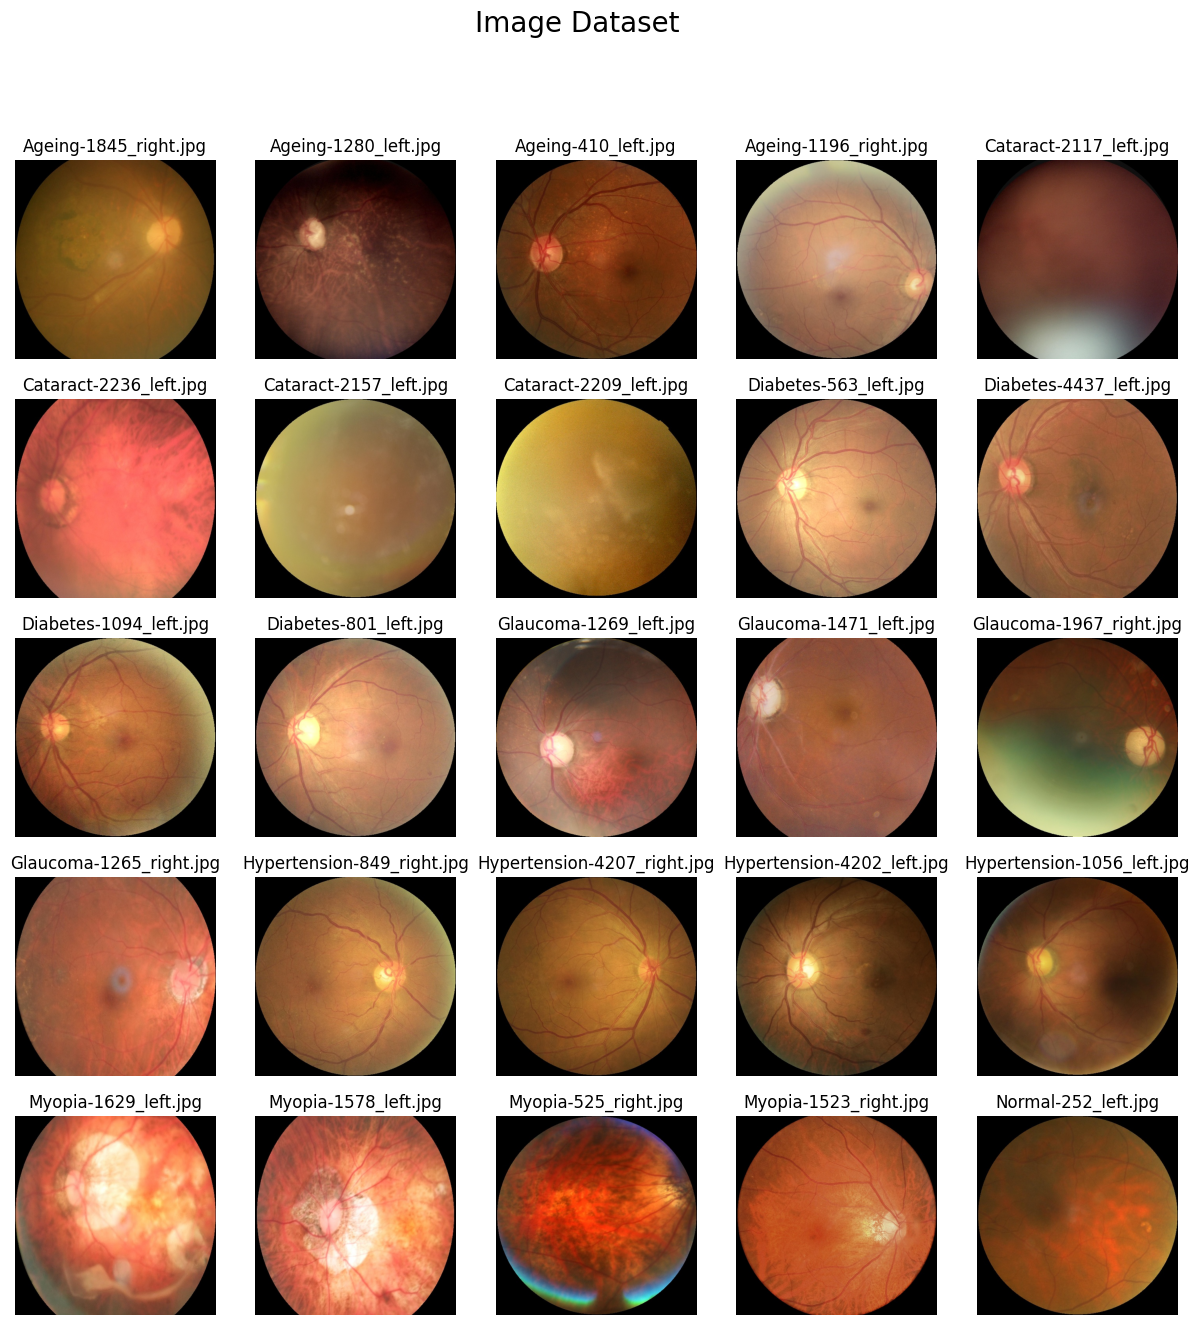

In [42]:
import cv2
def view_random_images(train_data, w=512,h=512):
    samples = train_data.groupby('class').apply(lambda x: x.sample(4)).reset_index(drop=True)
    images_path = list(samples['filename'])
    labels = list(samples['class'])
    
    plt.figure(figsize=(15, 15))
    plt.suptitle("Image Dataset", fontsize=20)

    for i in range(1, 26):
        plt.subplot(5, 5, i)
        image_path=os.path.join(data_set_img_path, images_path[i-1])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#        img = image_preprocessing(img, IMG_WIDTH, IMG_HEIGHT)
        img = cv2.resize(img, (w, h))
        img = img / 255.
        plt.imshow(img, aspect="auto")
        plt.title(f"{labels[i-1]}-{images_path[i-1].split('/')[-1]}")
        plt.axis(False);

view_random_images(train_df)